# Elizaveta Zavialova (i6213355)

PRA3024 (2021)

Assignment 1 - Gravitational waves data analysis:

part 1: Matched filter

part 2: Detector noise

part 3: Horizon distance

**Disclaimer:**

I have chosen PRA3024 to learn working with Python, but I have practically no previous experience with physics. Hence, in this assignment I struggled a lot and mostly just copied and re-arranged functions that we used in example assignment. I tried to interpret said functions and provide my reasoning for every step, but most of the parameters i used because they were provided in hints.



In [118]:
import sys
!{sys.executable} -m pip install lalsuite pycbc
from __future__ import division
import numpy
import lal
import lalsimulation
import matplotlib.pyplot as plt
from scipy import interpolate
from numpy import pi
from scipy import constants
from pycbc.conversions import *
from astropy import cosmology
from pycbc import waveform

**Matched filter**

- Part 1 and Part 2 of 'Matched filter' were completed me and my groupmates during the tutorial and approved by Ayatri, so I didn't change anything

"Download the data set from [1]. This data set contains a noise time series and an additional gravitational wave signal, where the sampling rate of the time series is 16384Hz.
The first column of the data set refers to the time. The second and third columns
are the data recorded by LIGO Hanford and Livingston, respectively. For the sake of
convenience in data analysis, we downsample the data at a sampling rate of 2048Hz."


File ‘H-H1_LOSC_CLN_4_V1-1187007040-2048.gwf’ already there; not retrieving.

File ‘L-L1_LOSC_CLN_4_V1-1187007040-2048.gwf’ already there; not retrieving.



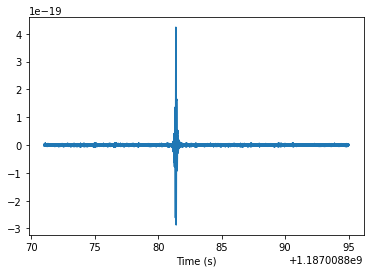

In [119]:
%matplotlib inline
from pycbc.catalog import Merger
from pycbc.filter import resample_to_delta_t, highpass
import pylab
from pycbc.waveform import get_td_waveform
from pycbc.frame import read_frame

!wget -nc https://dcc.ligo.org/public/0146/P1700349/001/H-H1_LOSC_CLN_4_V1-1187007040-2048.gwf
!wget -nc https://dcc.ligo.org/public/0146/P1700349/001/L-L1_LOSC_CLN_4_V1-1187007040-2048.gwf

# most of this code is copied and adapted from the 'GW150914' example
merger = Merger("GW170817")
strain, stilde = {}, {}
for ifo in ['L1', 'H1']:
    
    ts = merger.strain(ifo)  
    strain[ifo] = resample_to_delta_t(highpass(ts, 15.0), 1.0/2048)
    strain[ifo] = strain[ifo].crop(4, 4)
    stilde[ifo] = strain[ifo].to_frequencyseries()

#print (strain.delta_t)
pylab.plot(strain['L1'].sample_times, strain['L1'])
pylab.xlabel('Time (s)')
pylab.show()

Switching from L1 to H1 changes the shape of the graph.

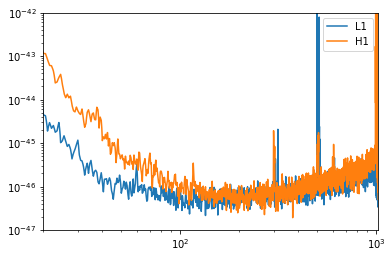

In [120]:
#finding PSD using Welch's method and then plotting PSD for both detectors

import pycbc.psd
from pycbc.psd import interpolate

psds = {}
for ifo in ['L1', 'H1']:

    delta_t = strain[ifo].delta_t
    seg_len = int(2 / delta_t)
    seg_stride = int(seg_len / 2)
    psds[ifo]  = pycbc.psd.welch(strain[ifo],
                      seg_len=seg_len,
                      seg_stride=seg_stride)
    
    psds[ifo] = interpolate(psds[ifo], stilde[ifo].delta_f)

    pylab.loglog(psds[ifo].sample_frequencies, psds[ifo], label=ifo)
    pylab.xlim(20, 1024)
    pylab.ylim(1e-47, 1e-42)
pylab.legend()

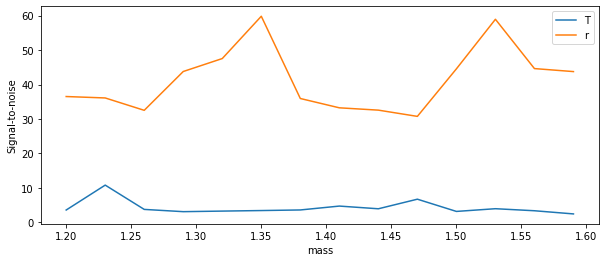

In [121]:
from pycbc.waveform import get_fd_waveform
from pycbc.filter import matched_filter
from pycbc.conversions import mass1_from_mchirp_q
import numpy


mass1 = numpy.arange(1.2, 1.6, 0.03 ) 
mass2 = mass1


hmax, smax, tmax, mmax, nsnr = None, {}, {}, 0, 0
snrs = {}
ifo = 'H1'
Snr_list = []
for i in range(len(mass1)):
    
 
    m = mass1[i] # Solar masses
    hp, hc = get_td_waveform(approximant="TaylorT4",
                     mass1=m,
                     mass2=m,
                     delta_t=strain[ifo].delta_t,
                     f_lower=25.0)

    
    hp.resize(len(strain[ifo]))
    template = hp.cyclic_time_shift(hp.start_time)
    
    snr = matched_filter(template, strain[ifo],
                     psd=psds[ifo], low_frequency_cutoff=15.0)
    
    snr_H1 = snr.crop(4 + 4, 4)


    Snr_list.append(max(abs(snr_H1)))
snrs[ifo] = Snr_list



ifo = 'L1'
Snr_list = []
for i in range(len(mass1)):
    #Generate a waveform with a given component mass; assumed equal mass, nonspinning
 
    m = mass1[i] # Solar masses
    hp, hc = get_td_waveform(approximant="TaylorT4",
                     mass1=m,
                     mass2=m,
                     delta_t=strain[ifo].delta_t,
                     f_lower=25.0)

    # We will resize the vector to match our data
    hp.resize(len(strain[ifo]))
    template = hp.cyclic_time_shift(hp.start_time)
    
    snr = matched_filter(template, strain[ifo],
                     psd=psds[ifo], low_frequency_cutoff=25.0)

    
    snr_H1 = snr.crop(4 + 4, 4)


    Snr_list.append(max(abs(snr_H1)))
snrs[ifo] = Snr_list


pylab.figure(figsize=[10, 4])
pylab.plot(mass1, snrs['H1'], label= 'H1')
pylab.plot(mass1, snrs['L1'], label= 'L1')
pylab.legend('True')
pylab.ylabel('Signal-to-noise')
pylab.xlabel('mass')
pylab.show()

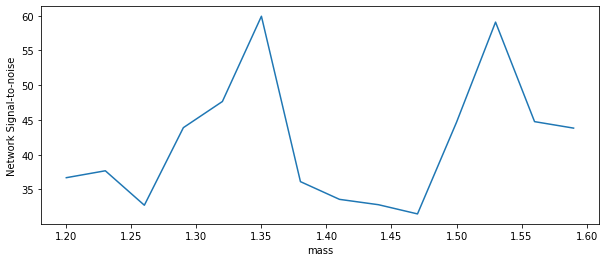

We found the best Mass1=Mass2 was 1.35 solar masses (detector frame)


In [122]:
nsnr = (numpy.array(snrs['H1'])**2 + numpy.array(snrs['L1'])**2)**0.5
ii = numpy.where(nsnr == max(nsnr))
pylab.figure(figsize=[10, 4])
pylab.plot(mass1, nsnr)

pylab.ylabel('Network Signal-to-noise')
pylab.xlabel('mass')
pylab.show()

print("We found the best Mass1=Mass2 was %2.2f solar masses (detector frame)" % mass1[ii])

**Part 3**

"Here, we would like to investigate the correlation in the parameter space of gravitational waves from compact binary coalescences. Let us consider a gravitational wave
h
∗
(t; m1, m2) generated from a binary with masses m1 = m2 = 10M. Now, we want
to understand how the nearby templates are correlated with that waveform. Calculate
the match between h
∗
(t; m1, m2) and the nearby templates that are generated assuming 5M ≤ m1, m2 ≤ 15M. Of course, one should have the maximum match (= 1)
when hi = h
∗
. You will see that the match between two nearby waveforms is not zero.
So, one can realize the gravitational waveforms are correlated for two nearby points
in the parameter space. This fact is used to produce a template bank for detecting
gravitational waves."

**Objective:**

To observe how change in parameters (suh as masses of the merging objects) introduce changes to the template waveforms.

1) Produce a template waveform m1=m2=10

2) Produce several templates with different masses and match it on the template

3) Plot matching



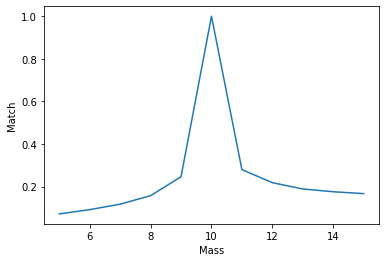

In [123]:
from pycbc.waveform import get_td_waveform
from pycbc.filter import match
from pycbc.psd import aLIGOZeroDetHighPower


f_low = 30
sample_rate = 4096

# original template waveform h*
hp, hc = get_td_waveform(approximant="TaylorT4",
                     mass1=10,
                     mass2=10,
                     delta_t=1.0/sample_rate,
                     f_lower=f_low)


# Generate waveforms to compare to h*
#it wasn't explicitely stated, but i assumed that for non-h* waveforms m1=m2,
# as seems to be the case on the graph in hints
match_list = []
for mass in range(5,16):
  sp, sc = get_td_waveform(approximant="TaylorT4",
  mass1=mass,
  mass2=mass,
  f_lower=f_low,
  delta_t=1.0/sample_rate)

  # Resize the waveforms to the same length
  tlen = max(len(sp), len(hp))
  sp.resize(tlen)
  hp.resize(tlen)

  # Generate the aLIGO ZDHP PSD
  delta_f = 1.0 / sp.duration
  flen = tlen//2 + 1
  psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)

  m, i = match(hp, sp, psd=psd, low_frequency_cutoff=f_low)
  # m - match, i - shifting index
  match_list.append(m)

mass_array = np.arange(5,16)
pylab.plot(mass_array, match_list)
pylab.ylabel('Match')
pylab.xlabel('Mass')
pylab.show()

**Assignment 2: Detector noise**

Exercise:

"Load the data of the LIGO Hanford detector from [2]. Plot the noise power spectral density (PSD) of that data. Test whether there is any gravitational wave signal present in the data or not? For this test, you can assume the GW signals can produce only from equal mass binary systems with a range between 5 to 10. We assume a thresholdon matched filter SNR of 8 to claim detection of GW."

**Objective:**

To identify whether data from LIGO detector contains a waveform, by using a Power Spectral Density to identify Signal-to-Noise ratio (SNR). SNR above 8 would be interpreted as detection of a signal.

In [124]:
# loading the data from LIGO detector as a time series
import numpy as np
d = np.load('noise_ts_4096Hz.npy')
import pycbc.types 
dt = d[:, 0]
d = pycbc.types.TimeSeries(d[:, 1], delta_t = dt[1]- dt[0])
data = d

In [125]:
# calculating Power Spectral Density (describes how power of the signal is distributed over frequency)
# using Welch method (to reduce variance)
from pycbc.psd import welch, interpolate
psds = interpolate(welch(d), 1.0 / d.duration)

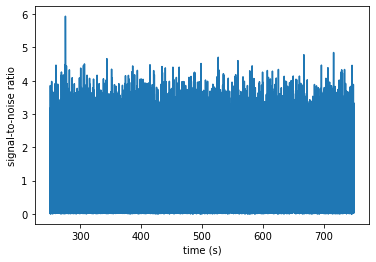

Maximum SNR 5.9348137468235205
Masses of objects that produce a waveform with max SNR is  8
GW was not detected


In [126]:
# Matched filtering
# creating a template waveform that would correspond to the binary system with 5<(m1=m2)<10
# and matching this waveform to the data

import pycbc.noise
import pycbc.psd
import pycbc.filter
import pycbc.waveform
import pylab
flow = 30 #Hz - lower frequency cut off boundary
stilde = data.to_frequencyseries()

maxMass = 0
maxSNR = 0

#choose a waveform with max SNR
for mass in range(5,11):
  hp, hc = pycbc.waveform.get_fd_waveform(approximant="TaylorF2",
                             mass1 = mass, mass2 = mass,
                             f_lower=flow, delta_f=stilde.delta_f)

  hp.resize(len(stilde))  
  snr = pycbc.filter.matched_filter(hp, stilde, psd=psds,
                                      low_frequency_cutoff=flow)

  # Remove regions corrupted by filter wraparound
  snr = snr[len(snr) // 4: len(snr) * 3 // 4]
  if (max(abs(snr))>maxSNR):
    maxSNR = max(abs(snr))
    maxMass = mass
    final_snr = snr



pylab.plot(final_snr.sample_times, abs(final_snr))
pylab.ylabel('signal-to-noise ratio')
pylab.xlabel('time (s)')
pylab.show()
print ( 'Maximum SNR', max(abs(final_snr)) )
print ("Masses of objects that produce a waveform with max SNR is ", maxMass)

if max(abs(final_snr))<8:
  print("GW was not detected")  

"Whiten the above data using its noise PSD. You can use PyCBC based function of theWelch method to estimate the PSD. Construct a histogram of the whitened data and show that the whiten data follows a Gaussian distribution with zero mean."

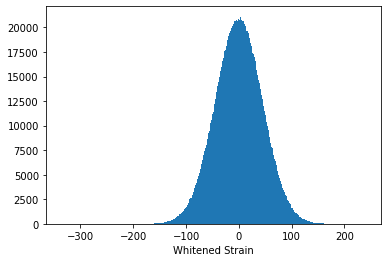

In [127]:
whitened = (data.to_frequencyseries() / psds**0.5).to_timeseries()
#whitened = whitened.highpass_fir(100, 512).lowpass_fir(150, 512)  # applying bandpass filter, since i couldnt do it with psd
whitened = whitened.time_slice(4, d.duration-4)
plt.hist(whitened, 1000)
pylab.xlabel('Whitened Strain')
pylab.show()

"In gravitational wave data analysis, we consider that the noise is stationary Gaussian.But in reality, the stationary assumption does not hold. Can you think of a test toshow that the stationarity does not hold?"

**Objective:**

Use a formula to calculate optimal signal-to-noise ratio to prove that noise isn't stationary 

[13.738390528653625, 14.121807670468662, 14.76059972905658, 15.915632593022174, 15.245841114300095, 17.50619199075492, 16.803048439281596, 15.268385508799804, 14.69796118521305, 14.514769159820187, 17.104748901616958, 15.412329535244746, 14.647888463582907, 14.59440175332441, 19.77918802031162, 16.800279966557916, 15.361384514472384, 16.62532281645935, 13.652666592383136, 14.958110083700685, 16.583806385134615, 16.703054478913742, 17.928662526661103, 15.113642901646642, 15.180085492742204, 16.835562745603095, 13.708708662197717, 18.156073004989178, 15.545846513432336, 16.31025088518785, 14.167426589526492, 17.85349393790611, 15.357292426066476, 18.34234761363069, 16.616064906695907, 14.332457500326997, 16.13443402624683, 14.268534021054839, 15.153058754546052, 16.034214473084646, 16.14951653069946, 15.650254759641019, 14.866589217876527, 14.781072138313785, 16.56077139921027, 15.469555815663439, 14.755973403575954, 17.31964164300682, 17.555099789337376, 17.20736921285748, 15.8039135500

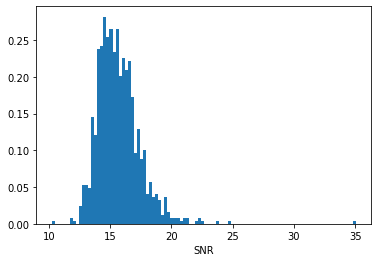

In [128]:
#get an arbitrary waveform to use in formula
from pycbc.waveform import get_fd_waveform
from pycbc.filter import sigmasq

delta_f=1.0/(200.0)

hp, hc = get_fd_waveform(approximant="TaylorF2",
mass1=3,
mass2=3,
delta_f=delta_f ,
distance = 500,
f_lower=20.0, f_final = 2048.0) #Luminosity distance = 500 Mpc

# divide data into chuncks(1000) and calculate their psd
snr_list = []
chunck = (int)(len(data)/1000)


for index in range(1000):
 
  data_chuncks = data[index*chunck : (index+1)*chunck]
  psd_list = interpolate(welch(data_chuncks), delta_f)
  snr = (pycbc.filter.sigmasq(hp, psd_list))**0.5

  snr_list.append(snr)

print(snr_list)
#make a histogram out of snr list
plt.hist(snr_list, 100, density=True)
pylab.xlabel('SNR')
pylab.show()  

**Horizon distance**


"The horizon distance of a GW detector is defined as a distance to the source for whichthe accumulated signal power (optimal SNR) is equal to a detection threshold of SNR(ρmin= 8) when the source is located overhead (θ= 0,π). Plot the horizon distancefor Advanced LIGO detector (assuming ’H1’ noise PSD) assuming a set of equal massbinary with a range of component masses between 5 to 500.  In this plot, you canassume that X-axis and Y-axis represent the total mass of the binary and horizondistance, respectively. For this analysis, first, generate the GW waves polarization infrequency domain,h+(f),h×(f)and construct the projection detector frame,h(f) =F+h+(f) +F×h×(f), whereF+andF×are the antenna pattern functions for the twopolarizations. Using the sky location(θ,φ)and polarization angle of the incoming GW,one can show that for ‘L’ shaped detectorF+,F×can be written as"

**Objective:**

To calculate the horizon distance for the LIGO detector and Einstein telescope

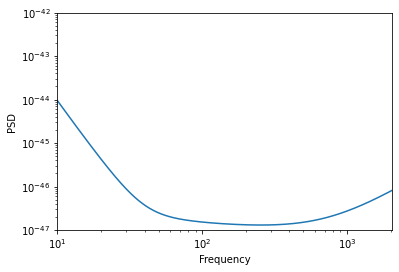

In [129]:
#get the psd for the aLIGO detector
flow = 4.0 # set up the lower cut off frequency
delta_f = 1.0 / 16
flen = int(2048.0/ (delta_f)) + 1
psd_L = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, flow)
psd_L.data[:int(flow/delta_f)] = np.inf #set the value outside the frequency range to infinity
psd_L.data[-1] = np.inf


pylab.loglog(psd_L.sample_frequencies, psd_L)
pylab.xlim(10, 2048)
pylab.ylim(1e-47, 1e-42)
pylab.xlabel("Frequency")
pylab.ylabel("PSD")
pylab.show()

#for some reason there are no spikes in expected

In [133]:
# generate waveforms of various masses and distances, calculate SNR 

# assumptions that I used for this part of the assignment:
# horizon distance is equal to the distance in get_fd_waveform function when SNR is 8
# mass1 = mass2
# SNR is inversly proportional to distance
# distance - Luminosity distance in Mpc

# my idea was to adjust distances in waveforms until snr is equal to 8 for each mass
# for some reason, there isn't a proper pattern
# could it be incorrect psd in the previous segment?

def get_horizon_distance(psd_input):
  distance_list = []
  mass_range = range(5, 2000, 250)

  for mass in mass_range:
    snr = 0
    distance = 3000

    while (int(snr) != 8):
      if (int(snr)) > 8:
        distance = distance + 250
        hp, hc = get_fd_waveform(approximant="TaylorF2",
                          mass1=mass,
                          mass2=mass,
                          delta_f=delta_f ,
                          f_lower=20, f_final = 2048,
                          distance = distance)
          
      #snr = (pycbc.filter.sigmasq(hp, psd_L))**0.5
        snr = (np.sum((4*hp*np.conj(hp)*hp.delta_f/psd_input).data).real)**0.5
        

      elif (int(snr)) < 8:
        distance = distance - 250
        hp, hc = get_fd_waveform(approximant="TaylorF2",
                          mass1=mass,
                          mass2=mass,
                          delta_f=delta_f ,
                          f_lower=20, f_final = 2048,
                          distance = distance)
          
      #snr = (pycbc.filter.sigmasq(hp, psd_L))**0.5
      
        snr = (np.sum((4*hp*np.conj(hp)*hp.delta_f/psd_input).data).real)**0.5
        

    distance_list.append(distance/1000.0)

      
    print("for total mass ", mass*2)
    print(" horizon distance is ", distance/1000.0) #Mpc-> Gpc
  print("distance list: ", distance_list)

  mass_range = [element * 2 for element in mass_range]
  pylab.plot(mass_range, distance_list)
  pylab.ylabel('Horizon distance, Gpc')
  pylab.xlabel('Total mass m1+m2')
  pylab.show()
  

for total mass  10
 horizon distance is  1.25
for total mass  510
 horizon distance is  30.0
for total mass  1010
 horizon distance is  53.0
for total mass  1510
 horizon distance is  74.25
for total mass  2010
 horizon distance is  94.0
for total mass  2510
 horizon distance is  113.25
for total mass  3010
 horizon distance is  131.5
for total mass  3510
 horizon distance is  149.5
distance list:  [1.25, 30.0, 53.0, 74.25, 94.0, 113.25, 131.5, 149.5]


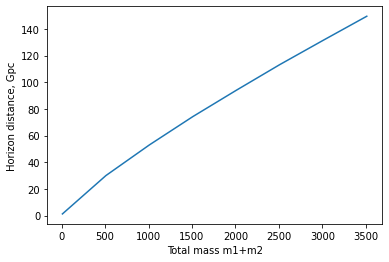

In [134]:
#generate horizon distance for LIGO detector
get_horizon_distance(psd_input=psd_L)  

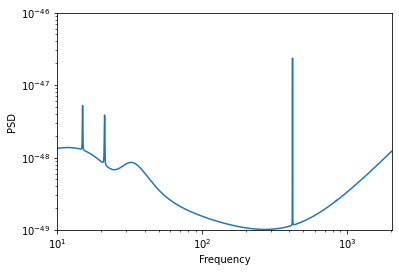

In [135]:
#get psd for Einstein's telescope

delta_f = 1.0 / 16
flen = int(2048.0/ (delta_f)) + 1
psd_E = pycbc.psd.EinsteinTelescopeP1600143(flen, delta_f, flow)
psd_E.data[:int(flow/delta_f)] = np.inf #set the value outside the frequency range to infinity
psd_E.data[-1] = np.inf

pylab.loglog(psd_E.sample_frequencies, psd_E)
pylab.xlim(10, 2048)
pylab.ylim(1e-49, 1e-46)
pylab.xlabel("Frequency")
pylab.ylabel("PSD")
pylab.show()

for total mass  10
 horizon distance is  11.5
for total mass  510
 horizon distance is  302.0
for total mass  1010
 horizon distance is  533.75
for total mass  1510
 horizon distance is  746.0
for total mass  2010
 horizon distance is  946.75
for total mass  2510
 horizon distance is  1139.25
for total mass  3010
 horizon distance is  1325.5
for total mass  3510
 horizon distance is  1506.75
distance list:  [11.5, 302.0, 533.75, 746.0, 946.75, 1139.25, 1325.5, 1506.75]


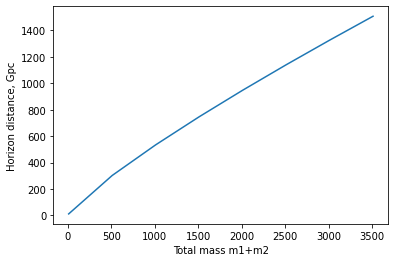

In [136]:
get_horizon_distance(psd_input=psd_E)